# **Informações do dataset**

- **Item_Identifier**: ID do produto
- **Item_Weight**: Peso do produto
- **Item_Fat_Content**: O quanto de gordura o produto possui
- **Item_Visibility**: % da área total de uma loja alocada para exibir o produto
- **Item_Type**: Categoria do produto
- **Item_MRP**: Preço máximo do produto
- **Outlet_Identifier**: ID da loja
- **Outlet_Establishment_Year**: Ano em que a loja iniciou
- **Outlet_Size**: Tamanho da loja
- **Outlet_Location_Type**: Nível da cidade em que a loja se localiza
- **Outlet_Type**: Se a loja é um supermercado ou uma loja menor
- **Item_Outlet_Sales**: Variavel alvo. Total de vendas do produto na loja

## Bibliotecas utilizadas

In [335]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split

In [295]:
import warnings
warnings.filterwarnings("ignore")

# **Carregando o arquivo e observando os dados**

In [296]:
df = pd.read_csv("./Big_Mart_Data.csv")

In [297]:
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [298]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# **Tratando os nulos**

## Coluna "Outlet_Size"

In [299]:
pd.pivot_table(data=df, index="Outlet_Type", columns="Outlet_Size", aggfunc=["size"], fill_value=0)

size             
Outlet_Size       High Medium Small
Outlet_Type                        
Grocery Store        0      0   528
Supermarket Type1  932    930  1860
Supermarket Type2    0    928     0
Supermarket Type3    0    935     0

In [300]:
filtro = df["Outlet_Size"].isna()
df[filtro]["Outlet_Type"].value_counts()

Outlet_Type
Supermarket Type1    1855
Grocery Store         555
Name: count, dtype: int64

### Como é possível observar, os valores nulos da coluna "Outlet_Size" correspondem a apenas dois valores da coluna "Outlet_Type". A partir disso, e utilizando a tabela pivot criada, é possível preencher esses valores nulos

### Primeiramente, tem-se que toda "Grocery Store" é considerada uma loja pequena, sendo possível preencher os valores nulos da coluna "Outlet_Size" com "small" toda vez que na coluna "Outlet_Type" aparecer "Grocery Store"

In [301]:
filtro1 = (df["Outlet_Size"].isna()) & (df["Outlet_Type"] == "Grocery Store")
df.loc[filtro1, "Outlet_Size"] = "Small"

### Após isso, apenas o valor "Supermarket Type1" aparece nos valores nulos restantes da coluna "Outlet_Size". Portanto, como esse valor aparece em todos os tamanhos possíveis de lojas, é possível observar a porcentagem exata para cada tamanho e preencher os nulos mantendo essa proporção

In [302]:
filtro2 = df["Outlet_Type"] == "Supermarket Type1"
df[filtro2]["Outlet_Size"].value_counts(normalize=True)

Outlet_Size
Small     0.499731
High      0.250403
Medium    0.249866
Name: proportion, dtype: float64

In [303]:
np.random.seed(42)
valores = ['Small'] * int(0.50 * 1855) + ['High'] * int(0.25 * 1855) + ['Medium'] * int(0.25 * 1855) #Lista com a proporção dos tamanhos de loja correspondentes ao supermercado tipo 1
while len(valores) < 1855:
    valores.append('Small')
np.random.shuffle(valores)

In [304]:
df.loc[df["Outlet_Size"].isna(), "Outlet_Size"] = valores

In [305]:
df[filtro2]["Outlet_Size"].value_counts(normalize=True)

Outlet_Size
Small     0.500090
High      0.250134
Medium    0.249776
Name: proportion, dtype: float64

In [306]:
df["Outlet_Size"].isna().sum()

0

## Coluna "Item_Weight"

In [307]:
df["Item_Weight"].describe()

count    7060.000000
mean       12.857645
std         4.643456
min         4.555000
25%         8.773750
50%        12.600000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64

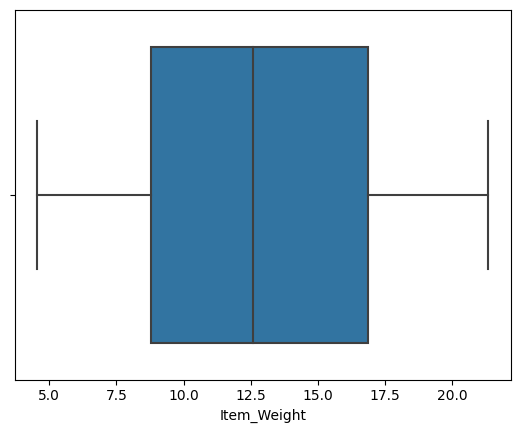

In [308]:
sns.boxplot(x=df["Item_Weight"])
plt.show()

### Como a coluna "Item_Weight" está bem destribuida, com média e mediana quase iguais, além de não possuir outliers, é possível preencher seus valores nulos com a média

In [309]:
weight_median = df["Item_Weight"].mean()
df["Item_Weight"].fillna(weight_median, inplace=True)

In [310]:
df["Item_Weight"].describe()

count    8523.000000
mean       12.857645
std         4.226124
min         4.555000
25%         9.310000
50%        12.857645
75%        16.000000
max        21.350000
Name: Item_Weight, dtype: float64

In [311]:
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

# **Analisando colunas numéricas**

In [312]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


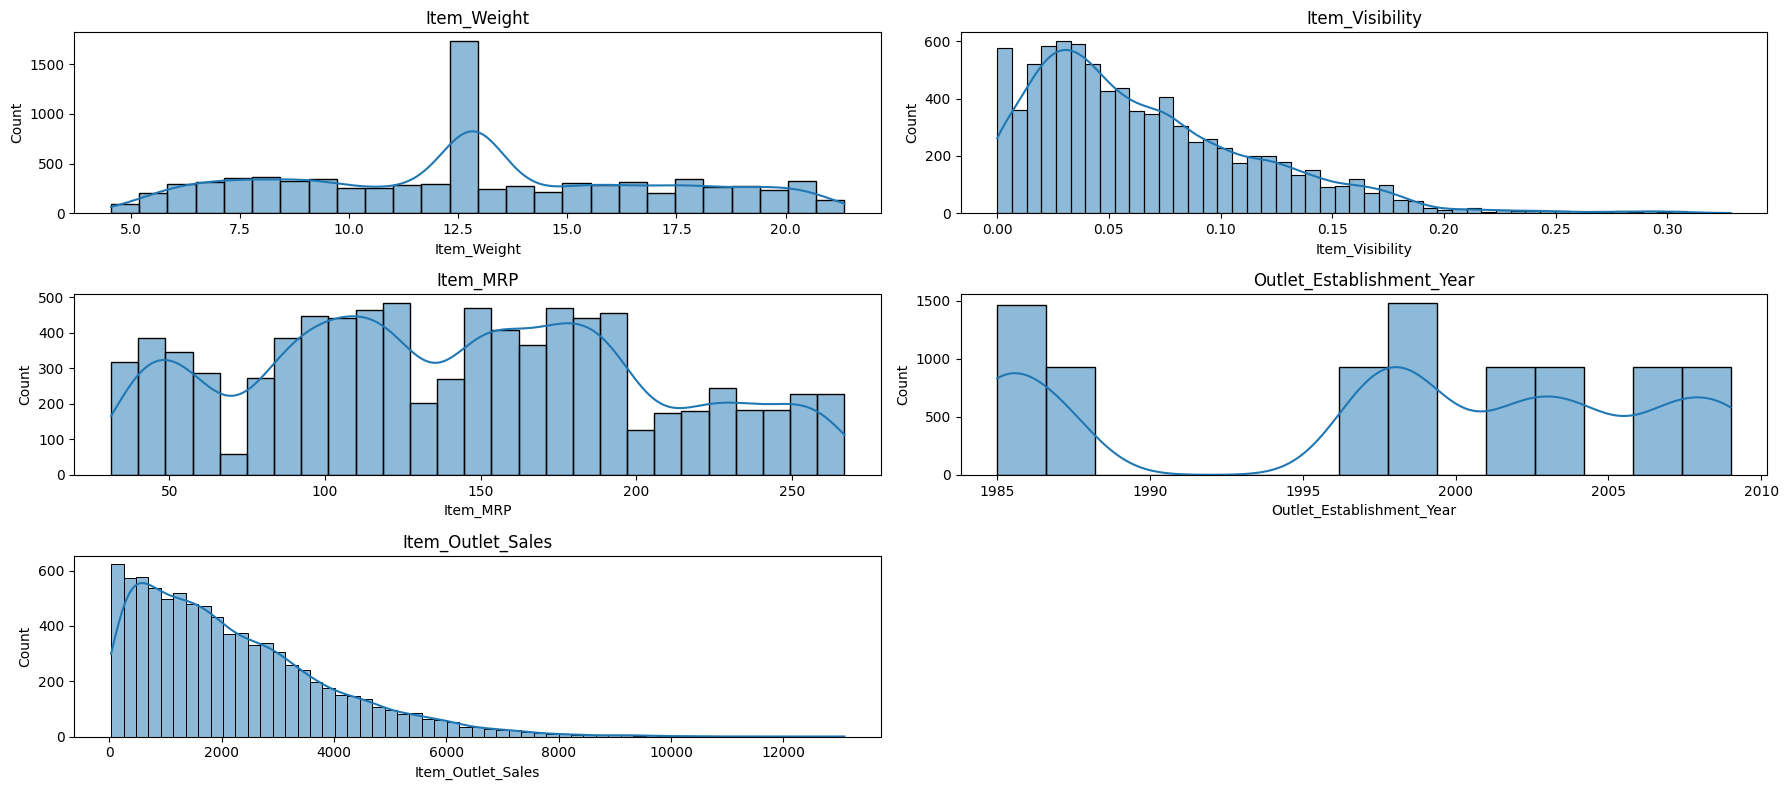

In [313]:
fig, ax = plt.subplots(3, 2, figsize=(18, 8))
ax = ax.ravel()
for i, col in enumerate(df.select_dtypes(include='number')):
    sns.histplot(df[col], kde=True, ax=ax[i])
    ax[i].set_title(col)
fig.delaxes(ax[5])
plt.tight_layout()
plt.show()

 - "Item_Weight" e "Item_MRP" não possuem outliers e se aproximam de uma distribuição normal
 - "Item_Visibility" e "Item_Outlet_Sales" possuem outliers e uma distribuição deslocada para a direita
 - "Item_Visibility" possui muitos valores 0. Como isso não faz sentido, já que para um item ser vendido numa loja ou supermercado ele deve estar em alguma prateleira visivel, podemos preencher esses valores com a mediana
 - "Outlet_Establishment_Year" possui apenas alguns valores. Nesse caso, criar uma coluna com a idade da loja pode ser útil ao invés do ano em que a loja foi aberta

# **Analisando colunas categóricas**

In [314]:
df.select_dtypes(include='object').head()

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDA15,Low Fat,Dairy,OUT049,Medium,Tier 1,Supermarket Type1
1,DRC01,Regular,Soft Drinks,OUT018,Medium,Tier 3,Supermarket Type2
2,FDN15,Low Fat,Meat,OUT049,Medium,Tier 1,Supermarket Type1
3,FDX07,Regular,Fruits and Vegetables,OUT010,Small,Tier 3,Grocery Store
4,NCD19,Low Fat,Household,OUT013,High,Tier 3,Supermarket Type1


## Coluna Item_Identifier

In [315]:
df["Item_Identifier"].sample(20)

8292    FDF56
3127    DRI11
8507    FDN28
2178    FDO23
107     FDG12
4999    FDV33
5114    FDS22
7708    FDK03
7596    FDG12
7512    FDA07
318     FDB53
4924    NCZ53
8414    DRO47
4203    FDA21
416     FDF11
5470    FDC40
4380    FDD56
5027    FDC45
2033    FDS33
718     FDN20
Name: Item_Identifier, dtype: object

In [316]:
df["Item_Identifier"].str.slice(0,2).value_counts()

Item_Identifier
FD    6125
NC    1599
DR     799
Name: count, dtype: int64

### A coluna "Item_Identifier" pode ser utilizada para criar uma coluna que indica a categoria do item. FD = Food, NC = Non-Consumable, DR = Drink

## Restante das colunas categóricas

In [317]:
for col in df.select_dtypes(include='object'):
    if col != "Item_Identifier":
        print(df[col].value_counts())
        print("#"*64)

Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64
################################################################
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64
################################################################
Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: count, dtype: int64
###############################################

### A coluna "Item_Fat_Content" possui apenas dois valores, onde LF, reg e low fat são apenas variações de Low Fat e Regular.

## **Melhorando as colunas do dataset e selecionando as colunas para EDA**

 - Preencher os valores 0 da coluna "Item_Visibility" pela mediana
 - Criar uma coluna denominada "Years_Active" a partir da coluna "Outlet_Establishment_Year"
 - Criar a coluna "Item_Category" a partir da coluna "Item_Identifier"
 - Ajustar a coluna "Item_Fat_Content" para conter apenas 2 valores

## Item_Visibility

In [318]:
valores_zero = df["Item_Visibility"] == 0
mediana_visibilidade = df["Item_Visibility"].median()
df.loc[valores_zero, "Item_Visibility"] = mediana_visibilidade

## Years_Active

In [319]:
sorted(df["Outlet_Establishment_Year"].unique())

[1985, 1987, 1997, 1998, 1999, 2002, 2004, 2007, 2009]

In [320]:
df["Years_Active"] = 2009 - df["Outlet_Establishment_Year"]

In [321]:
sorted(df["Years_Active"].unique())

[0, 2, 5, 7, 10, 11, 12, 22, 24]

## Item_Category

In [322]:
categorias = {"FD": "Food",
              "DR": "Drink",
              "NC": "Non-consumable"}
df["Item_Category"] = df["Item_Identifier"].str.slice(0,2).map(categorias)

In [323]:
df["Item_Category"].value_counts()

Item_Category
Food              6125
Non-consumable    1599
Drink              799
Name: count, dtype: int64

## Item_Fat_Content

In [324]:
qtd_gordura = {"LF": "Low Fat",
               "low fat": "Low Fat",
               "reg": "Regular"}
df["Item_Fat_Content"] = df["Item_Fat_Content"].replace(qtd_gordura)

In [325]:
df["Item_Fat_Content"].value_counts()

Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64

## Com isso, o dataset está sem nenhum nulo e com colunas corretamente categorizadas. A partir disso, podemos dropar a coluna "Item_Identifier" e realizar a EDA

In [326]:
df = df.drop(columns=["Item_Identifier"])

In [327]:
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Years_Active,Item_Category
0,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,10,Food
1,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,0,Drink
2,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,10,Food
3,19.20,Regular,0.053931,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,11,Food
4,8.93,Low Fat,0.053931,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,22,Non-consumable


In [328]:
df.isna().sum()

Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
Years_Active                 0
Item_Category                0
dtype: int64

# **EDA**

## Colunas Numéricas

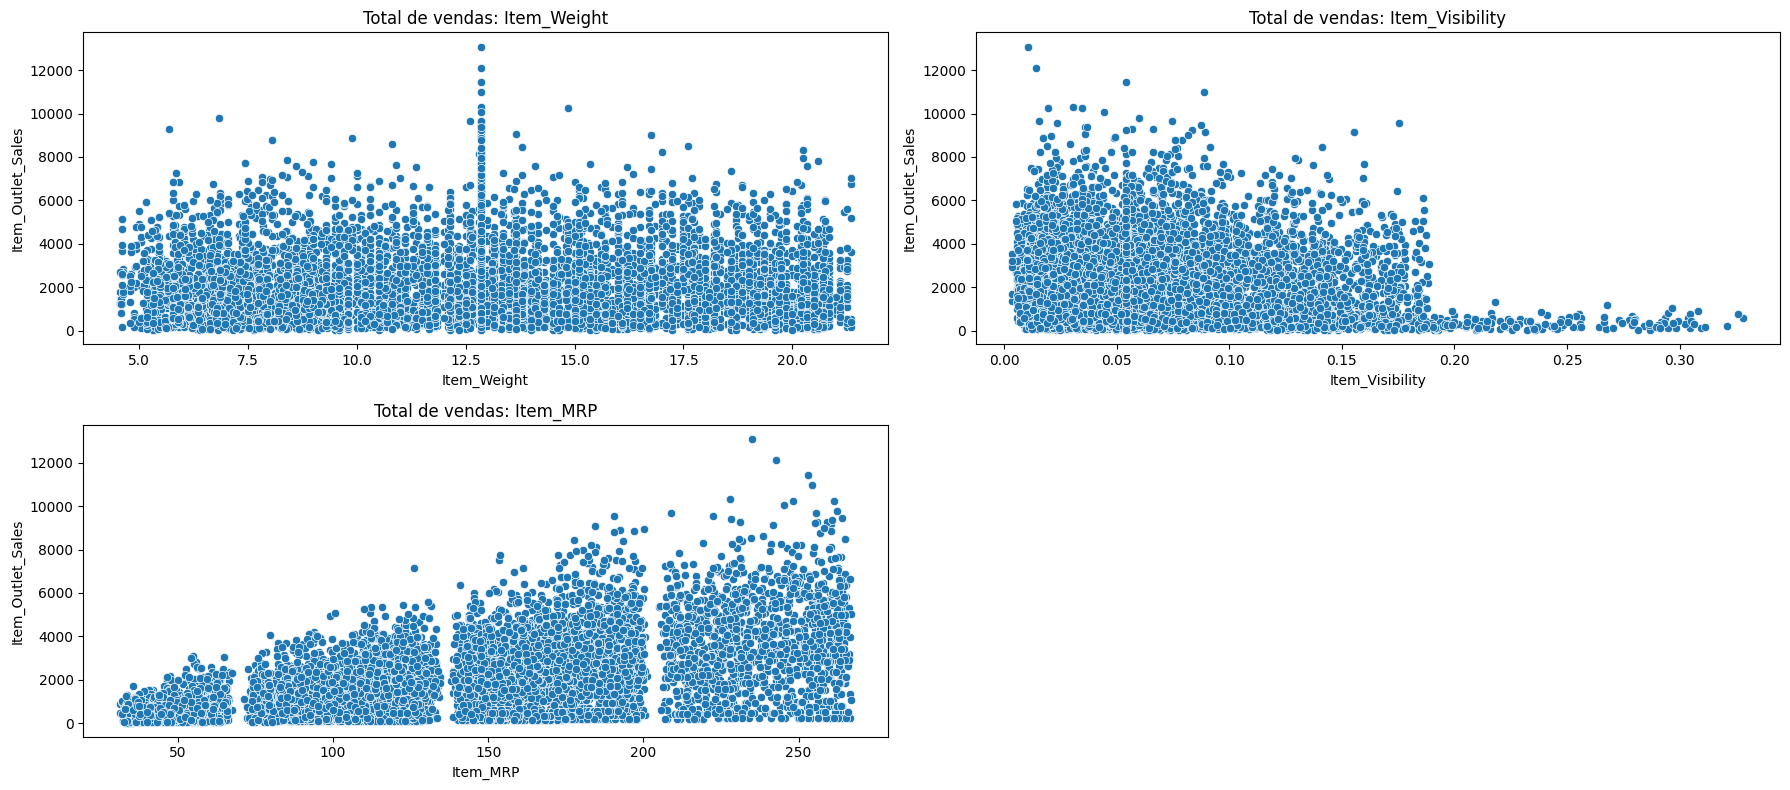

In [329]:
fig, ax = plt.subplots(2, 2, figsize=(18, 8))
ax = ax.ravel()
colunas = ["Item_Weight", "Item_Visibility", "Item_MRP"]
for i, col in enumerate(colunas):
    if col != "Item_Outlet_Sales":
        sns.scatterplot(x=df[col], y=df["Item_Outlet_Sales"], ax=ax[i])
        ax[i].set_title(f"Total de vendas: {col}")
fig.delaxes(ax[3])
plt.tight_layout()
plt.show()

 - "Item_Weight" basicamente não possui nenhum efeito na venda do produto
 - "Item_Visibility" apresenta um comportamento inesperado. A partir do momento que um item possui 20% ou mais de visibilidade, sua venda cai bruscamente
 - "Item_MRP" indica que os produtos com os maiores preços máximos são aqueles que mais fazem dinheiro para as lojas

## Colunas Categóricas

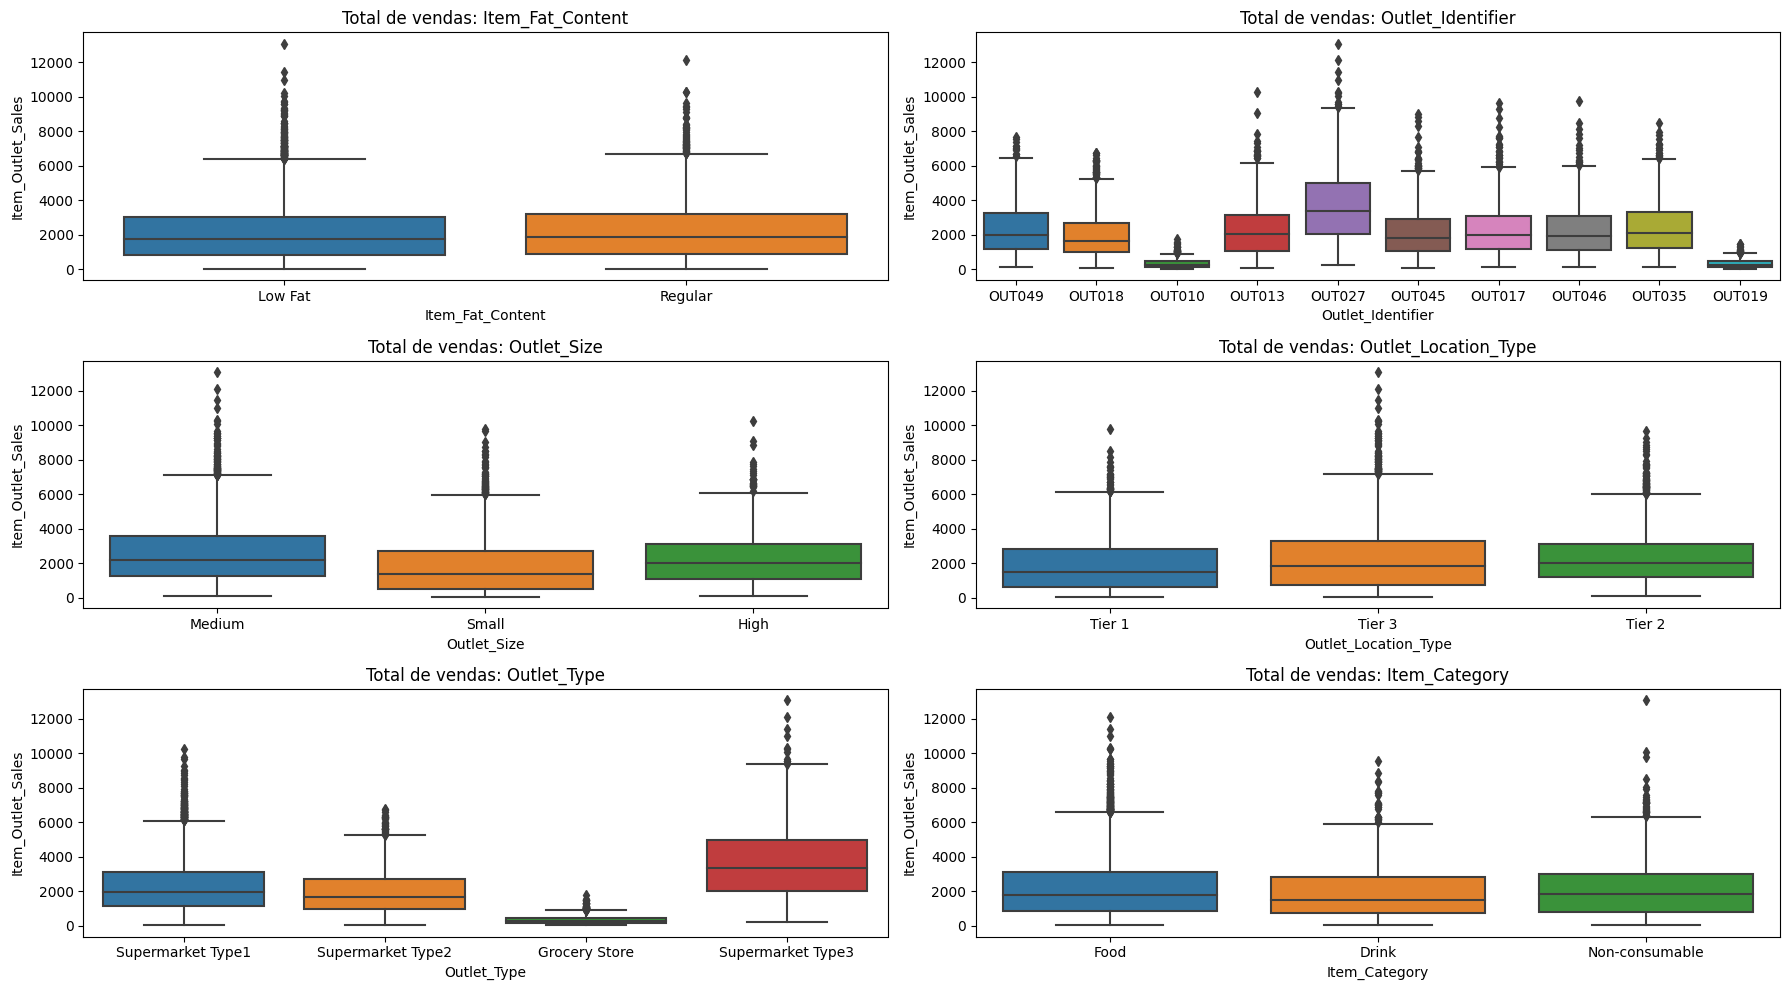

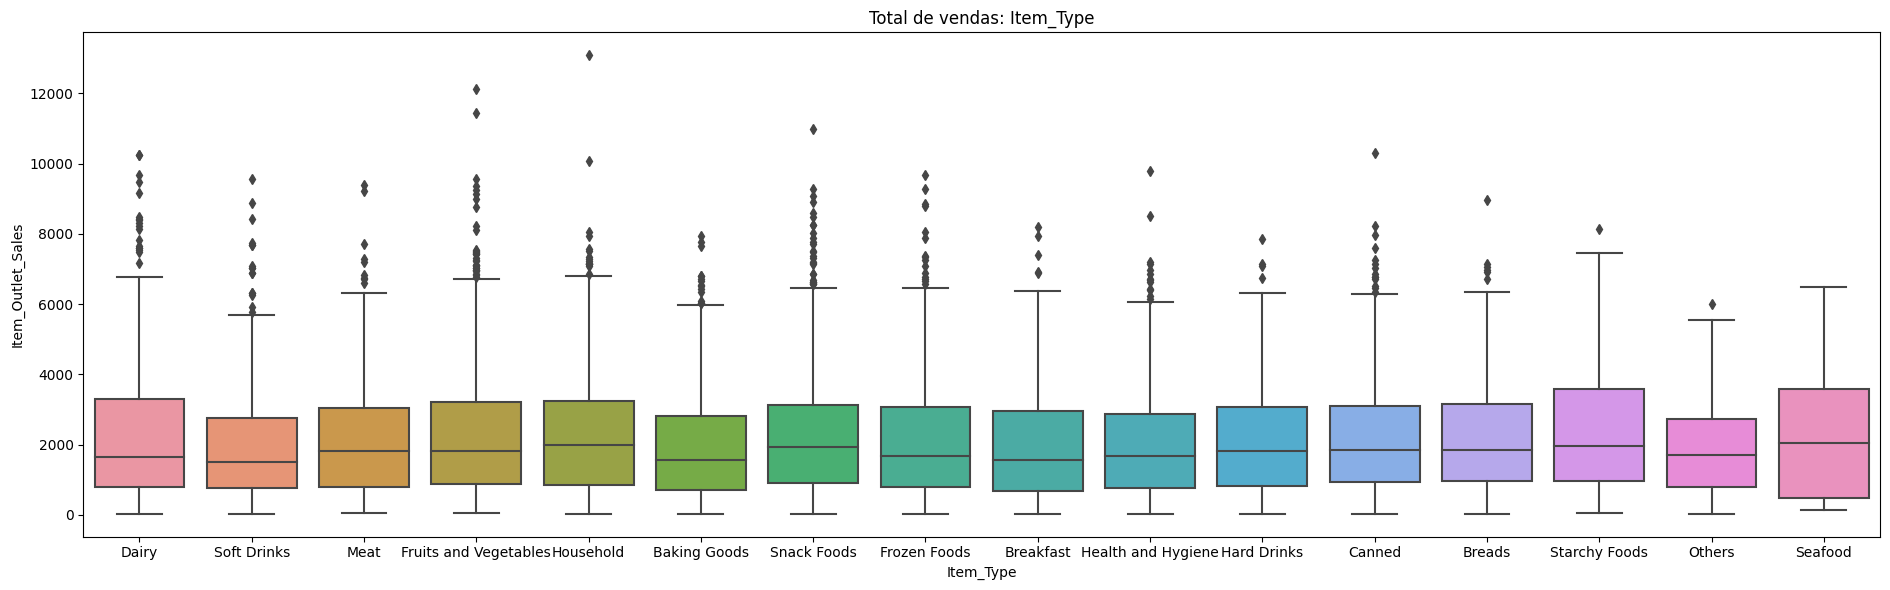

In [330]:
fig, ax = plt.subplots(3, 2, figsize=(18, 10))
ax = ax.ravel()
for i, col in enumerate(df.select_dtypes(include='object').drop(columns=["Item_Type"])):
        sns.boxplot(x=df[col], y=df["Item_Outlet_Sales"], ax=ax[i])
        ax[i].set_title(f"Total de vendas: {col}")
plt.tight_layout()
plt.show()
plt.figure(figsize=(19,6))
sns.boxplot(x=df["Item_Type"], y=df["Item_Outlet_Sales"])
plt.title(f"Total de vendas: Item_Type")   
plt.tight_layout()
plt.show()

 - Um produto com pouca gordura ou quantidade de gordura regular aparentemente não influencia o consumidor. As duas categorias vendem basicamente o mesmo
 - Lojas de tamanho médio tendem a vender um pouco mais que as de tamanho grande, e as de menor tamanho são as que menos vendem
 - Supermercados do tipo 3 são de longe os que mais vendem, com os do tipo 1 e 2 quase que empatados. Lojas de conveniência vendem extremamente menos que os supermercados
 - Lojas 10 e 19 vendem muito abaixo das outras, provavelmente são lojas de conveniência. A loja 27 vende muito mais que todas e o resto das lojas vendem basicamente o mesmo
 - O tipo de localização não aparenta afetar muito a quantidade de vendas, sendo os 3 tipos bem próximos nesse quesito
 - As categorias dos produtos são bem equilibradas, com a categoria de não consumiveis possuindo alguns outliers bem acima do resto
 - Os tipos de produtos são todos basicamente empatados em vendas. Como a coluna "Item_Category" engloba essa coluna e como essa é uma análise mais superficial, podemos excluir essa coluna

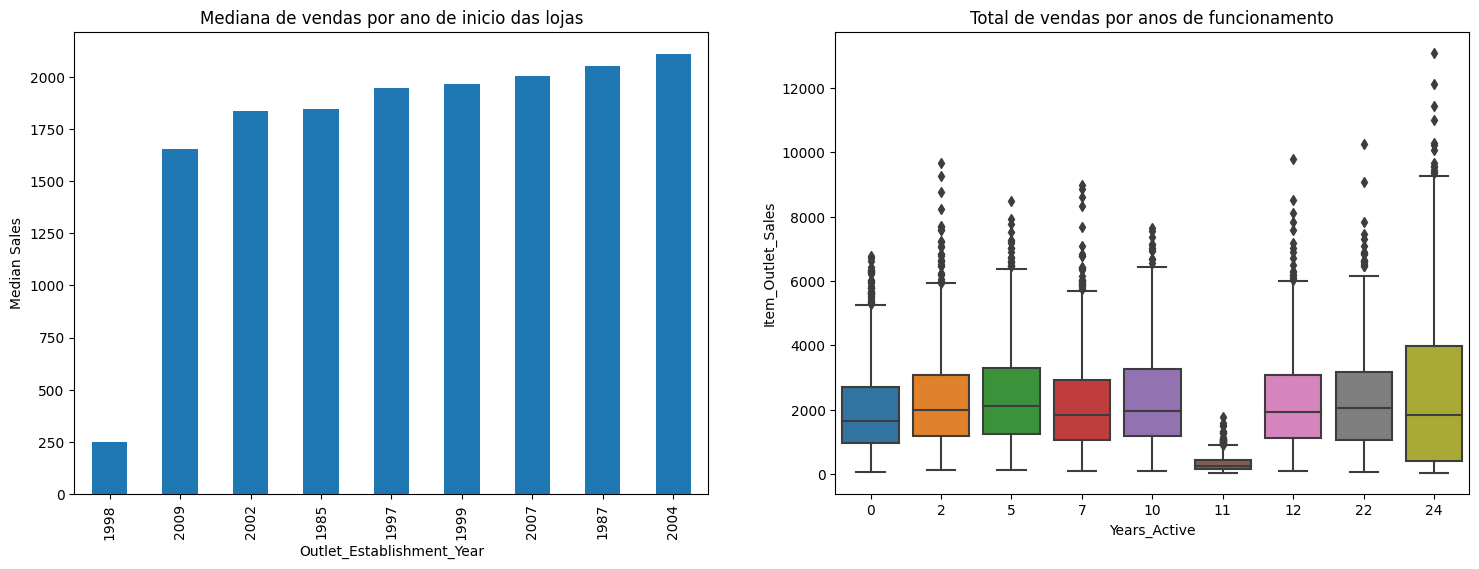

In [331]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax = ax.ravel()
df.groupby("Outlet_Establishment_Year")["Item_Outlet_Sales"].median().sort_values().plot.bar(ax=ax[0])
ax[0].set_title(f"Mediana de vendas por ano de inicio das lojas")
ax[0].set_ylabel("Median Sales")
sns.boxplot(x=df["Years_Active"], y=df["Item_Outlet_Sales"], ax=ax[1])
ax[1].set_title(f"Total de vendas por anos de funcionamento")
plt.show()

 - O ano de 1998 foi um terrível ano para as vendas, sendo a sua mediana algo em torno de 6 a 7 vezes menor que a mediana de vendas do segundo pior ano
 - 2009 é o segundo pior ano. Isso pode ter acontecido por conta da crise de 2008, ou esse banco de dados pode ter sido elaborado até o meio ou começo de 2009. Não temos como saber se é um dataset real ou sintético.
 - A loja mais antiga é a loja que mais vende, sendo todas as outras bem empatadas entre si, tirando a loja com 11 anos de funcionamento. Isso indica que pode não existir uma relação forte entre anos de funcionamento e vendas 

# **Preparação do dataset para a modelagem**

## Verificando a correlação das variáveis

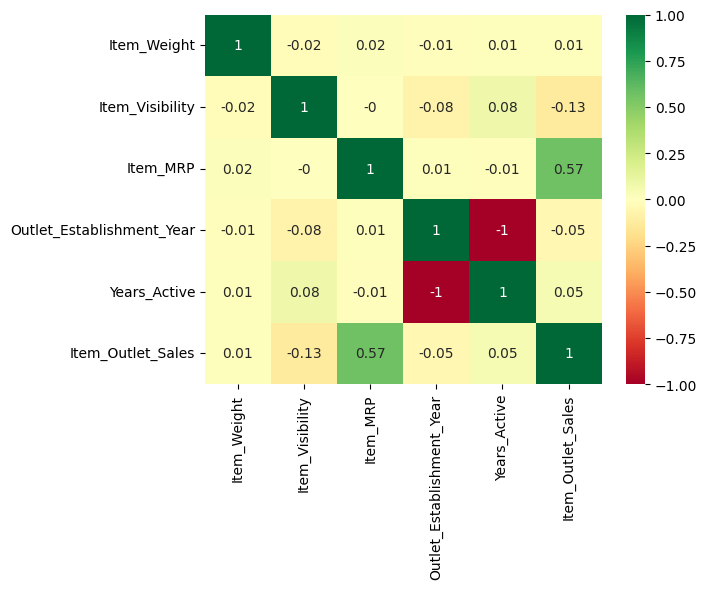

In [332]:
colunas_num = ["Item_Weight", "Item_Visibility", "Item_MRP", "Outlet_Establishment_Year", "Years_Active", "Item_Outlet_Sales"]
sns.heatmap(df[colunas_num].corr().round(2), annot=True, cmap="RdYlGn")
plt.show()

 - Como esperado, "Outlet_Establishment_Year" e "Years_Active" possuem correlação inversa, mas nenhuma das duas possuem algum tipo de correlação com a variável alvo. Nesse caso, podemos nos desfazer da coluna "Outlet_Establishment_Year" e testar modelos com a coluna "Years_Active" 
 - Apenas a coluna "Item_MRP" apresentou algum tipo de correlação com a variável alvo, como foi possível perceber no gráfico realizado na EDA

In [333]:
df = df.drop(columns=["Outlet_Establishment_Year", "Item_Type"])

In [334]:
df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Years_Active,Item_Category
0,9.30,Low Fat,0.016047,249.8092,OUT049,Medium,Tier 1,Supermarket Type1,3735.1380,10,Food
1,5.92,Regular,0.019278,48.2692,OUT018,Medium,Tier 3,Supermarket Type2,443.4228,0,Drink
2,17.50,Low Fat,0.016760,141.6180,OUT049,Medium,Tier 1,Supermarket Type1,2097.2700,10,Food
3,19.20,Regular,0.053931,182.0950,OUT010,Small,Tier 3,Grocery Store,732.3800,11,Food
4,8.93,Low Fat,0.053931,53.8614,OUT013,High,Tier 3,Supermarket Type1,994.7052,22,Non-consumable


## Enconding das variáveis categóricas

In [336]:
categorical_columns = ["Item_Fat_Content", "Outlet_Identifier", "Outlet_Size", "Outlet_Location_Type", "Outlet_Type", "Item_Category"]
df_final = df.copy()

In [337]:
encoder_OneHot = OneHotEncoder(sparse_output=False)
encoded = encoder_OneHot.fit_transform(df[categorical_columns])
encoded_columns = encoder_OneHot.get_feature_names_out(categorical_columns)
encoded_df = pd.DataFrame(encoded, columns=encoded_columns)
df_final = pd.concat([df_final.drop(columns=categorical_columns), encoded_df], axis=1)

In [338]:
df_final.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Years_Active,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,...,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Category_Drink,Item_Category_Food,Item_Category_Non-consumable
0,9.30,0.016047,249.8092,3735.1380,10,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,5.92,0.019278,48.2692,443.4228,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,17.50,0.016760,141.6180,2097.2700,10,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,19.20,0.053931,182.0950,732.3800,11,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,8.93,0.053931,53.8614,994.7052,22,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## Separação dos dados e escalonamento

In [340]:
X = df_final.drop(columns=["Item_Outlet_Sales"])
y = df_final["Item_Outlet_Sales"]

In [341]:
scaler = MinMaxScaler()
scaler_cols = ["Item_Weight", "Item_Visibility", "Item_MRP", "Years_Active"]
X_numeric = X[scaler_cols]
X_numeric_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=scaler_cols)
X[scaler_cols] = X_numeric_scaled

In [346]:
X.head()

,Item_Weight,Item_Visibility,Item_MRP,Years_Active,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,...,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Category_Drink,Item_Category_Food,Item_Category_Non-consumable
0,0.282525,0.038399,0.927507,0.416667,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.081274,0.048346,0.072068,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.770765,0.040593,0.468288,0.416667,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.871986,0.155030,0.640093,0.458333,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.260494,0.155030,0.095805,0.916667,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [347]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# **Modelagem e análise**

## Funções para output dos resultados

In [135]:
def metricas(y_test, y_pred, model_name):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    metrics_dict = {
        "Mean Squared Error (MSE)": [mse],
        "Root Mean Squared Error (RMSE)": [rmse],
        "Mean Absolute Error (MAE)": [mae],
        "R-squared (R2)": [r2]
    }
    
    metrics_df = pd.DataFrame(metrics_dict, index=[model_name])
    return metrics_df

In [136]:
def grafico_regressao(y_pred, model):
    y_pred_serie = pd.Series(y_pred)
    y_test_serie = y_test.copy()
    y_pred_serie.reset_index(drop=True, inplace=True)
    y_test_serie.reset_index(drop=True, inplace=True)
    df_grafico = pd.DataFrame({'Valores Preditos': y_pred_serie.values, 'Valores Reais': y_test_serie.values})
    sns.lmplot(data=df_grafico, x="Valores Preditos", y="Valores Reais", ci=None, line_kws={"color": "red"}, height=5, aspect=2)
    plt.title(f"Valor predito vs Valor real: Modelo {model}")
    plt.xlabel("Valores preditos")
    plt.ylabel("Valores Reais")
    plt.show()

## Regressão Linear

In [348]:
reg = linear_model.LinearRegression(n_jobs=-1)
reg.fit(X_train, y_train)
y_reg_pred = reg.predict(X_test)

In [349]:
metricas1 = metricas(y_test, y_reg_pred, 'Reg_linear')
metricas1

,Mean Squared Error (MSE),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),R-squared (R2)
Reg_linear,1.206607e+06,1098.456805,810.351666,0.569222


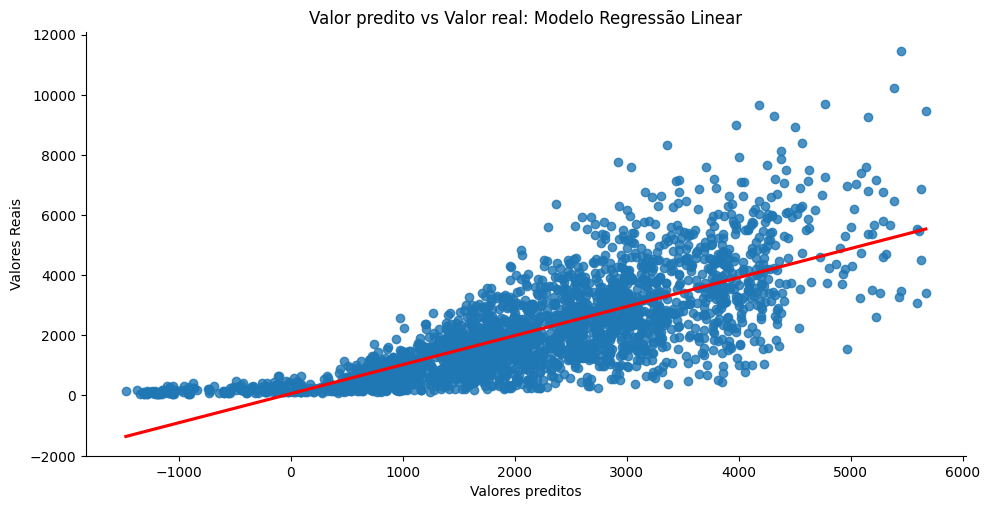

In [350]:
grafico_regressao(y_reg_pred, 'Regressão Linear')

## Lasso

In [351]:
lasso = linear_model.Lasso(random_state=42)
params_lasso = {'alpha':[0.1, 0.5, 1, 10, 100], 'max_iter':[1000, 3000, 5000], 'tol': [0.0001, 0.001, 0.01, 0.1]}
search_lasso = GridSearchCV(lasso, params_lasso, cv=5)
search_lasso.fit(X_train, y_train)
print(search_lasso.best_estimator_)

Lasso(alpha=1, random_state=42, tol=0.001)


In [352]:
lasso_final = linear_model.Lasso(alpha=1, tol=0.001, random_state=42)
lasso_final.fit(X_train,y_train)
y_lasso_pred = lasso_final.predict(X_test)

In [353]:
metricas2 = metricas(y_test, y_lasso_pred, 'Lasso')
metricas2

,Mean Squared Error (MSE),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),R-squared (R2)
Lasso,1.204333e+06,1097.42106,808.374464,0.570034


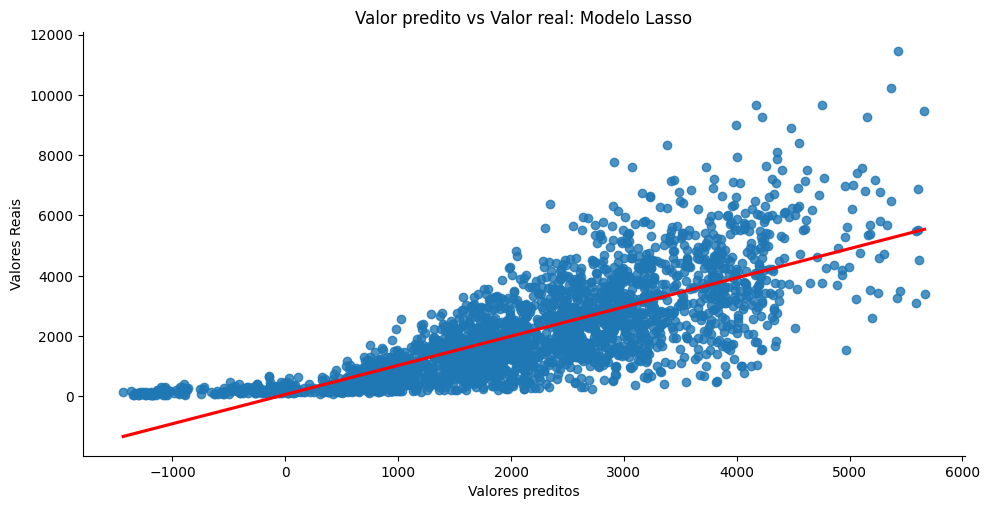

In [354]:
grafico_regressao(y_lasso_pred, 'Lasso')

## Ridge

In [355]:
ridge = linear_model.Ridge(random_state=42)
params_ridge = {'alpha':[0.1, 0.5, 1, 10, 100], 'max_iter':[1000, 3000, 5000], 'tol': [0.0001, 0.001, 0.01, 0.1]}
search_ridge = GridSearchCV(ridge, params_ridge, cv=5)
search_ridge.fit(X_train, y_train)
print(search_ridge.best_estimator_)

Ridge(alpha=1, max_iter=1000, random_state=42)


In [356]:
ridge_final = linear_model.Ridge(alpha=1, max_iter=1000, random_state=42)
ridge_final.fit(X_train,y_train)
y_ridge_pred = ridge_final.predict(X_test)

In [357]:
metricas3 = metricas(y_test, y_ridge_pred, 'Ridge')
metricas3

,Mean Squared Error (MSE),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),R-squared (R2)
Ridge,1.205474e+06,1097.940966,808.918675,0.569626


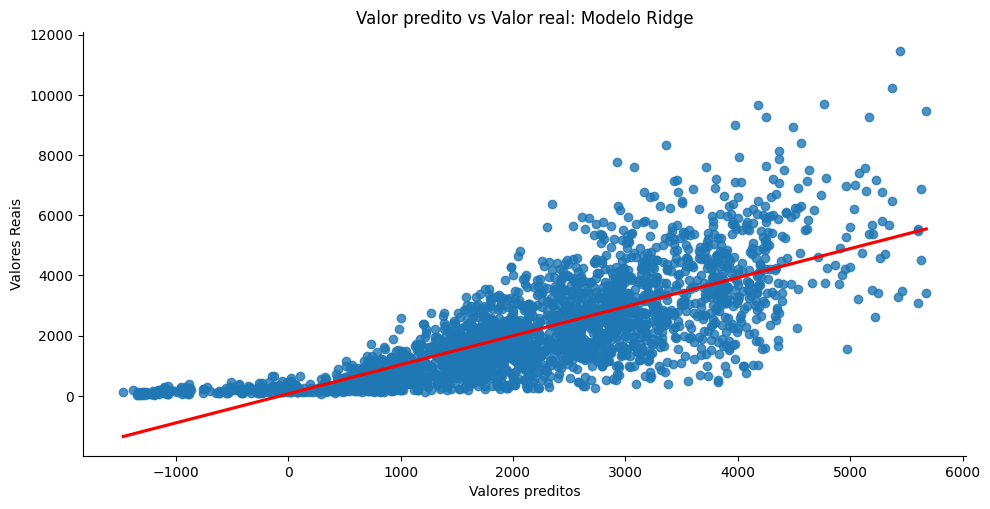

In [358]:
grafico_regressao(y_ridge_pred, 'Ridge')

## Árvore de Regressão

In [359]:
dtr = DecisionTreeRegressor(random_state=42)
params_dtr = {'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'], 'max_depth': [4, 6, 8, 10, 12,], 'min_samples_split': [3, 5, 10, 15], 'min_samples_leaf': [8, 11, 14, 17, 20]}
search_dtr = GridSearchCV(dtr, params_dtr, cv=5)
search_dtr.fit(X_train, y_train)
print(search_dtr.best_estimator_)

DecisionTreeRegressor(max_depth=6, min_samples_leaf=20, min_samples_split=3,
                      random_state=42)


In [360]:
dtr_final = DecisionTreeRegressor(max_depth=6, min_samples_leaf=20, min_samples_split=3, random_state=42)
dtr_final.fit(X_train, y_train)
y_dtr_pred = dtr_final.predict(X_test)

In [363]:
metricas4 = metricas(y_test, y_dtr_pred, 'Árvore')
metricas4

,Mean Squared Error (MSE),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),R-squared (R2)
Árvore,1.143141e+06,1069.177948,746.225674,0.59188


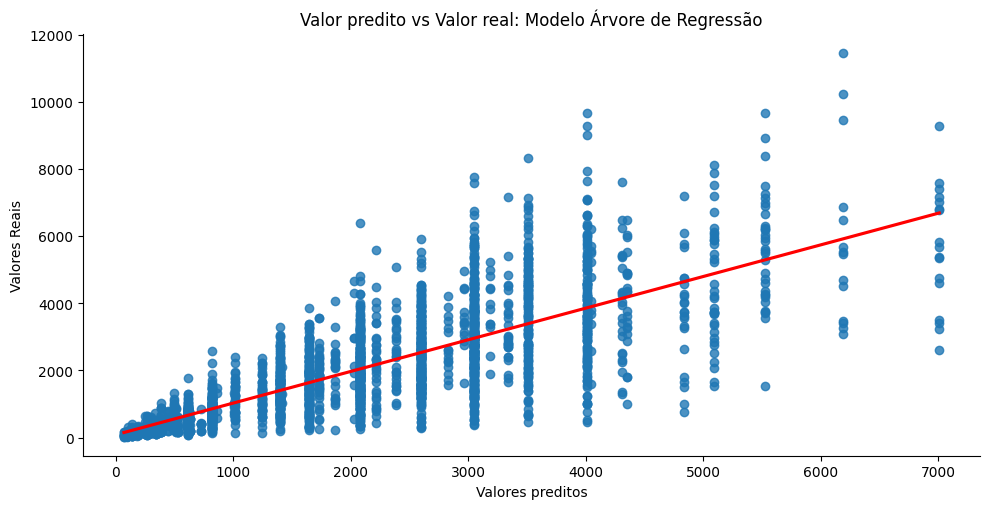

In [362]:
grafico_regressao(y_dtr_pred, 'Árvore de Regressão')

# **Conclusão**

In [364]:
metricas_list = [metricas1, metricas2, metricas3, metricas4]
result_df = pd.concat(metricas_list)
result_df.sort_values(by="R-squared (R2)", ascending=False)

,Mean Squared Error (MSE),Root Mean Squared Error (RMSE),Mean Absolute Error (MAE),R-squared (R2)
Árvore,1.143141e+06,1069.177948,746.225674,0.591880
Lasso,1.204333e+06,1097.421060,808.374464,0.570034
Ridge,1.205474e+06,1097.940966,808.918675,0.569626
Reg_linear,1.206607e+06,1098.456805,810.351666,0.569222


### Todos os modelos tiveram resultados muito semelhantes, principalmente a regressão linear e suas variações lasso e ridge, que basicamente obtiveram resultados completamente identicos. O modelo de árvore de regressão foi um pouco diferente, apresentando os melhores resultados. Esse modelo obteve os menores erros e o maior R², sendo o modelo a ser escolhido para esse dataset.
### Porém, um ponto a ser considerado é a veracidade dos dados. Não temos como saber se esse dataset é sintético ou não, e isso pode afetar qualquer tipo de análise. Todas as colunas categóricas tinham seus valores muito balanceados entre si ao serem relacionados com a variável alvo, o que é algo bem incomum. Assumindo que esse dataset seja sintético, dependendo de como seus dados foram gerados, é muito difícil um modelo conseguir obter um resultado relevante.